In [20]:
import os
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd 

import os
import matplotlib.pyplot as plt
import cv2

# Path

In [21]:
dataset_path = 'SF-MASK' 
train_dir = 'SF-MASK/train'
test_dir = 'SF-MASK/test'

# Fonctions

In [22]:
def load_dataset(dataset_path):
    data = []
    labels = []
    categories = ['compliant', 'non-compliant']
    
    for category in categories:
        path = os.path.join(dataset_path, category)
        label = categories.index(category)
        
        for img in os.listdir(path):
            if img.lower().endswith(('png', 'jpg', 'jpeg')):  
                img_path = os.path.join(path, img)
                image = cv2.imread(img_path)
                image = cv2.resize(image, (224, 224))  
                data.append(image)
                labels.append(label)
    
    return np.array(data), np.array(labels)

In [23]:
import random
from tensorflow.keras.preprocessing import image

def test_model_on_random_images(model, test_dir, num_images=5, target_size=(128, 128)):
    """
    Teste le modèle sur plusieurs images aléatoires de l'ensemble de test et affiche les résultats.
    
    :param model: Modèle TensorFlow/Keras entraîné
    :param test_dir: Chemin du dossier contenant les sous-dossiers 'compliant' et 'non-compliant'
    :param num_images: Nombre d'images aléatoires à tester
    :param target_size: Taille des images pour le modèle (par défaut 224x224)
    """
    categories = ['compliant', 'non-compliant']
    images_and_predictions = []

    for category in categories:
        category_path = os.path.join(test_dir, category)
        if not os.path.exists(category_path):
            print(f"Le dossier {category_path} n'existe pas.")
            continue
        
        images = random.sample(os.listdir(category_path), min(num_images, len(os.listdir(category_path))))

        for img_name in images:
            img_path = os.path.join(category_path, img_name)
            
            img = image.load_img(img_path, target_size=target_size)
            img_array = image.img_to_array(img) / 255.0
            img_array = np.expand_dims(img_array, axis=0)  
            
            prediction = model.predict(img_array)
            predicted_label = "Non-Compliant" if prediction[0] > 0.5 else "Compliant"
            
            images_and_predictions.append((img, predicted_label, category))

    plt.figure(figsize=(15, num_images * 3))
    for i, (img, predicted_label, true_label) in enumerate(images_and_predictions):
        plt.subplot(len(images_and_predictions) // num_images, num_images, i + 1)
        plt.imshow(img)
        plt.title(f"True: {true_label}\nPred: {predicted_label}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()


# First EfficientNet Model

**128x128**

## Preprocessing

In [24]:
# Générateur pour l'entraînement avec augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,                # Normalisation
    rotation_range=20,                # Rotation aléatoire
    width_shift_range=0.2,            # Décalage horizontal
    height_shift_range=0.2,           # Décalage vertical
    shear_range=0.2,                  # Cisaillement
    zoom_range=0.2,                   # Zoom
    horizontal_flip=True,             # Retournement horizontal
    validation_split=0.2              # Séparation train/val
)

# Générateur pour le test sans augmentation
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Générateur pour l'ensemble d'entraînement
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),          # Redimensionner les images
    batch_size=32,                   # Taille des lots
    class_mode='binary',             # Classification binaire
    subset='training'                # Ensemble d'entraînement
)

# Générateur pour l'ensemble de validation
val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='validation'              # Ensemble de validation
)

# Générateur pour l'ensemble de test
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

Found 29726 images belonging to 2 classes.
Found 7430 images belonging to 2 classes.
Found 8670 images belonging to 2 classes.


## Model

In [25]:
# Charger EfficientNetB0 pré-entraîné
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(128, 128, 3))

# Ajouter des couches personnalisées pour la classification binaire
x = base_model.output
x = GlobalAveragePooling2D()(x)       # Réduction de dimension
x = Dropout(0.5)(x)                   # Régularisation
predictions = Dense(1, activation="sigmoid")(x)  # Activation sigmoïde pour la classification binaire

# Construire le modèle complet
model = Model(inputs=base_model.input, outputs=predictions)

# Geler les couches du modèle de base pour l'entraînement initial
for layer in base_model.layers:
    layer.trainable = False


In [26]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    steps_per_epoch=train_generator.samples // 32,
    validation_steps=val_generator.samples // 32
)

Epoch 1/5
928/928 [==============================] - 141s 150ms/step - loss: 0.6911 - accuracy: 0.5560 - val_loss: 0.6827 - val_accuracy: 0.5753
Epoch 2/5
928/928 [==============================] - 143s 154ms/step - loss: 0.6898 - accuracy: 0.5570 - val_loss: 0.6809 - val_accuracy: 0.5756
Epoch 3/5
928/928 [==============================] - 145s 156ms/step - loss: 0.6871 - accuracy: 0.5622 - val_loss: 0.6876 - val_accuracy: 0.5757
Epoch 4/5
928/928 [==============================] - 146s 158ms/step - loss: 0.6868 - accuracy: 0.5655 - val_loss: 0.6815 - val_accuracy: 0.5757
Epoch 5/5
928/928 [==============================] - 158s 170ms/step - loss: 0.6873 - accuracy: 0.5642 - val_loss: 0.6812 - val_accuracy: 0.5757


## Fine Tuning

In [27]:
for layer in base_model.layers:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    steps_per_epoch=train_generator.samples // 32,
    validation_steps=val_generator.samples // 32
)

Epoch 1/5
928/928 [==============================] - 531s 568ms/step - loss: 0.2034 - accuracy: 0.9183 - val_loss: 1.7611 - val_accuracy: 0.4199
Epoch 2/5
928/928 [==============================] - 642s 692ms/step - loss: 0.1398 - accuracy: 0.9483 - val_loss: 1.4431 - val_accuracy: 0.4247
Epoch 3/5
928/928 [==============================] - 620s 668ms/step - loss: 0.1244 - accuracy: 0.9521 - val_loss: 1.1002 - val_accuracy: 0.4243
Epoch 4/5
928/928 [==============================] - 498s 537ms/step - loss: 0.1175 - accuracy: 0.9564 - val_loss: 1.1778 - val_accuracy: 0.3883
Epoch 5/5
928/928 [==============================] - 699s 754ms/step - loss: 0.1061 - accuracy: 0.9600 - val_loss: 1.2276 - val_accuracy: 0.5400


In [28]:
model.save_weights("./models/efficientnet_mask_detection_weights_128.h5")

In [29]:
# Évaluer sur l'ensemble de test
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

271/271 [==============================] - 30s 112ms/step - loss: 0.7446 - accuracy: 0.7092
Test Accuracy: 70.92%


## Results

Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x35f2b3eb0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x35f2b3eb0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x35f2b3eb0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 0s 19ms/step


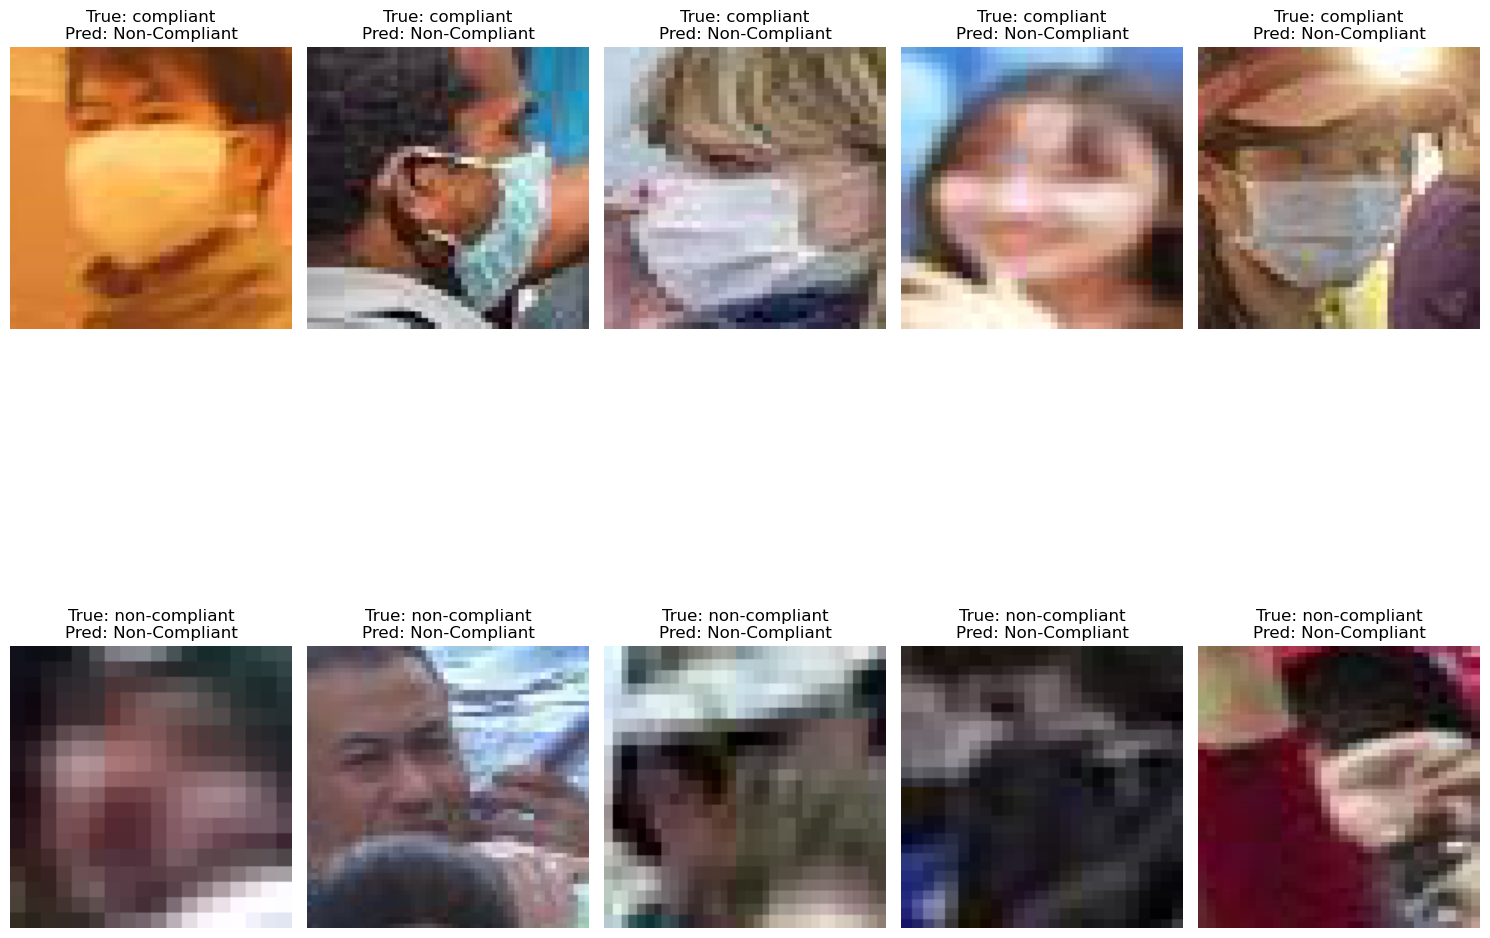

In [30]:
test_dir = "SF-MASK/test" 
test_model_on_random_images(model, test_dir, num_images=5)

## Graphics

# Other Images Resolution

# New model 

**160x160**

## Pre-processing

In [31]:
# Générateur pour l'entraînement avec augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,                # Normalisation
    rotation_range=20,                # Rotation aléatoire
    width_shift_range=0.2,            # Décalage horizontal
    height_shift_range=0.2,           # Décalage vertical
    shear_range=0.2,                  # Cisaillement
    zoom_range=0.2,                   # Zoom
    horizontal_flip=True,             # Retournement horizontal
    validation_split=0.2              # Séparation train/val
)

# Générateur pour le test sans augmentation
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Générateur pour l'ensemble d'entraînement
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(160, 160),          # Redimensionner les images
    batch_size=32,                   # Taille des lots
    class_mode='binary',             # Classification binaire
    subset='training'                # Ensemble d'entraînement
)

# Générateur pour l'ensemble de validation
val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(160, 160),
    batch_size=32,
    class_mode='binary',
    subset='validation'              # Ensemble de validation
)

# Générateur pour l'ensemble de test
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(160, 160),
    batch_size=32,
    class_mode='binary'
)

Found 29726 images belonging to 2 classes.
Found 7430 images belonging to 2 classes.
Found 8670 images belonging to 2 classes.


In [32]:
# Charger EfficientNetB0 pré-entraîné
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(160, 160, 3))

# Ajouter des couches personnalisées pour la classification binaire
x = base_model.output
x = GlobalAveragePooling2D()(x)       # Réduction de dimension
x = Dropout(0.5)(x)                   # Régularisation
predictions = Dense(1, activation="sigmoid")(x)  # Activation sigmoïde pour la classification binaire

# Construire le modèle complet
model = Model(inputs=base_model.input, outputs=predictions)

# Geler les couches du modèle de base pour l'entraînement initial
for layer in base_model.layers:
    layer.trainable = False

In [33]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    steps_per_epoch=train_generator.samples // 32,
    validation_steps=val_generator.samples // 32
)

Epoch 1/5
928/928 [==============================] - 217s 232ms/step - loss: 0.6918 - accuracy: 0.5530 - val_loss: 0.6849 - val_accuracy: 0.5756
Epoch 2/5
928/928 [==============================] - 214s 230ms/step - loss: 0.6894 - accuracy: 0.5597 - val_loss: 0.6849 - val_accuracy: 0.5754
Epoch 3/5
928/928 [==============================] - 223s 240ms/step - loss: 0.6876 - accuracy: 0.5613 - val_loss: 0.7156 - val_accuracy: 0.4247
Epoch 4/5
928/928 [==============================] - 234s 252ms/step - loss: 0.6885 - accuracy: 0.5626 - val_loss: 0.6842 - val_accuracy: 0.5757
Epoch 5/5
928/928 [==============================] - 250s 269ms/step - loss: 0.6869 - accuracy: 0.5665 - val_loss: 0.6816 - val_accuracy: 0.5757


In [34]:
for layer in base_model.layers:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    steps_per_epoch=train_generator.samples // 32,
    validation_steps=val_generator.samples // 32
)

Epoch 1/5
928/928 [==============================] - 842s 904ms/step - loss: 0.1897 - accuracy: 0.9269 - val_loss: 1.3463 - val_accuracy: 0.4247
Epoch 2/5
928/928 [==============================] - 898s 967ms/step - loss: 0.1387 - accuracy: 0.9483 - val_loss: 46.2069 - val_accuracy: 0.5199
Epoch 3/5
928/928 [==============================] - 878s 946ms/step - loss: 0.1208 - accuracy: 0.9556 - val_loss: 1.3347 - val_accuracy: 0.4243
Epoch 4/5
928/928 [==============================] - 858s 924ms/step - loss: 0.1116 - accuracy: 0.9582 - val_loss: 3.6854 - val_accuracy: 0.4242
Epoch 5/5
928/928 [==============================] - 775s 835ms/step - loss: 0.1011 - accuracy: 0.9618 - val_loss: 1.7504 - val_accuracy: 0.6127


In [35]:
model.save_weights("./models/efficientnet_mask_detection_weights_160.h5")

1/1 [==============================] - 0s 22ms/step


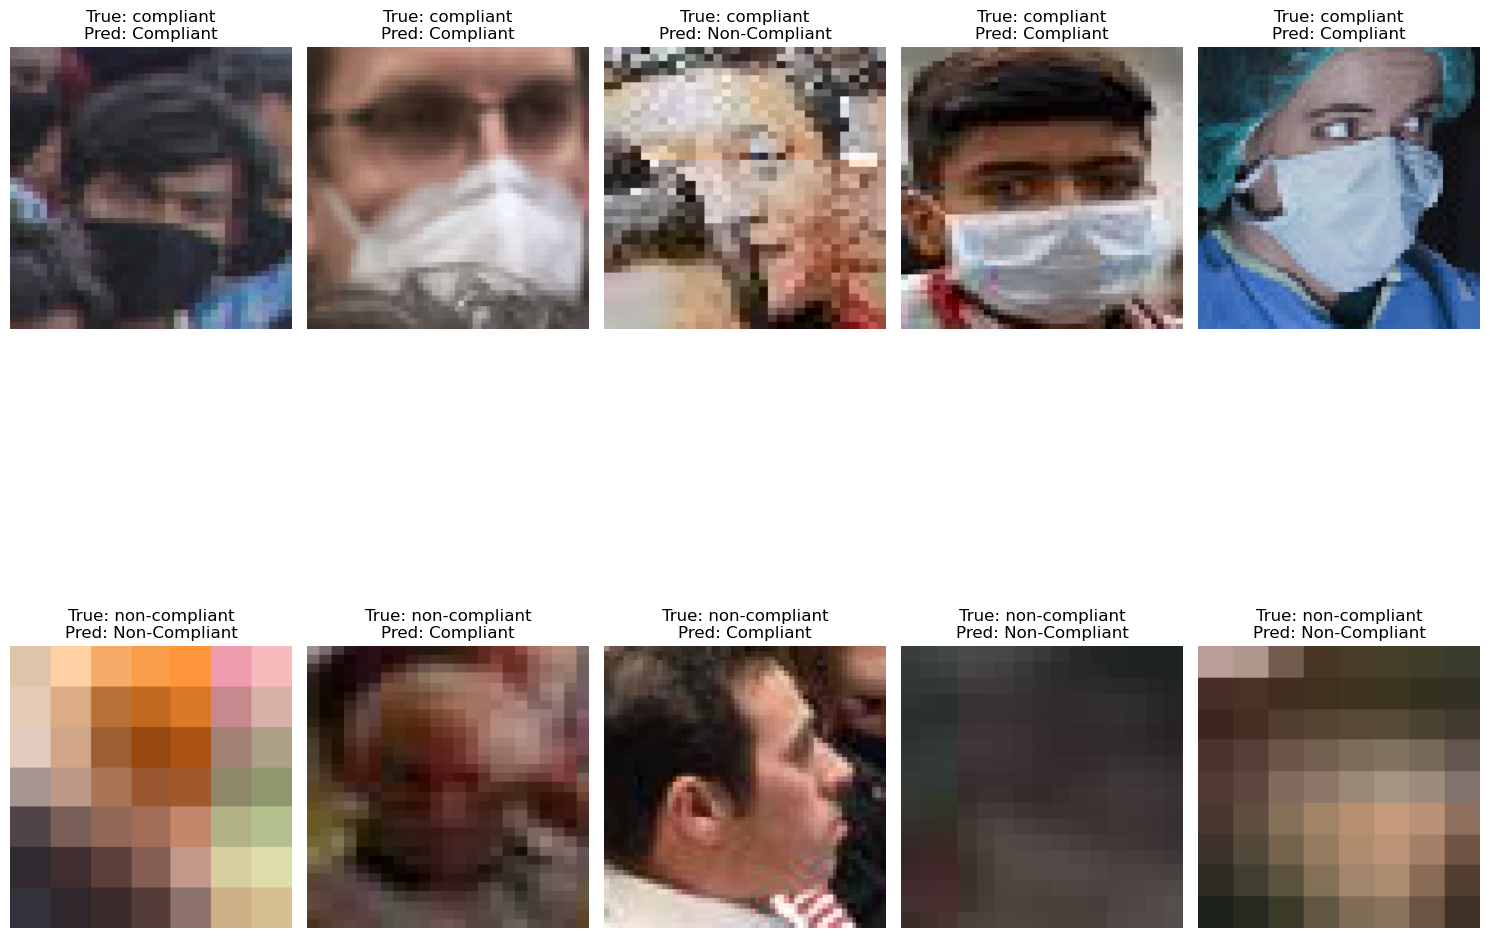

In [37]:
test_dir = "SF-MASK/test" 
test_model_on_random_images(model, test_dir, num_images=5, target_size=(160,160))